# Personal vs Promotional: Modeling Mompreneur Narratives in #SAHM TikTok
Ruth Jin\
Dec. 23, 2025
### Background
Mothers who run home-based businesses (mompreneurs) use TikTok not only to share daily life but also to promote products, services, and income opportunities. The #SAHM (Stay-At-Home Mom) community has become a major hub for these creators, blending personal narratives about motherhood with entrepreneurial messaging. Prior research shows that social media narratives often mix emotional storytelling with promotional intent, shaping audience trust and engagement (Abidin, 2016). However, little work has examined how mompreneur creators specifically navigate the line between personal storytelling and promotional content, especially at scale.\
\
My research uses large-scale text analysis and machine-learning classification to distinguish personal vs promotional storytelling styles in #SAHM mompreneur TikTok posts. I will evaluate how these styles relate to audience engagement, how they vary across creators, and how they have changed over time from 2018–2025.

### Research Question
How do mompreneur creators within the #SAHM TikTok community balance personal and promotional storytelling content, and how does this balance relate to audience engagement at the creator level?


### Sub Questions
**Descriptive**: How frequently do mompreneur creators adopt personal, promotional, or mixed storytelling styles in posts, and how does the degree of mixing vary across creators?\
**Predictive**: To what extent does the degree of promotional storytelling (measured continuously) predict engagement outcomes for mompreneur posts and creators?



## Table of Contents
1. [Load Data](#Load-Data)

## Load Data

**Notes:**
- My data

In [38]:
# Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [39]:
# Paths to public-safe artifacts produced in Notebook A (Private notebook that include user-sensitive information)
POST_PATH = "data_sanitized/post_level_sanitized.csv"
CREATOR_PATH = "data_sanitized/creator_stats.csv"
CREATOR_YEAR_PATH = "data_sanitized/creator_year_stats.csv"
METRICS_PATH = "data_sanitized/model_metrics.csv"
HUMAN_CM_PATH = "data_sanitized/human_validation_confusion.csv"

In [40]:
# Load
df_posts = pd.read_csv(POST_PATH)
df_creator = pd.read_csv(CREATOR_PATH)
df_creator_year = pd.read_csv(CREATOR_YEAR_PATH)

model_metrics = pd.read_csv(METRICS_PATH) if os.path.exists(METRICS_PATH) else None
human_cm = pd.read_csv(HUMAN_CM_PATH) if os.path.exists(HUMAN_CM_PATH) else None

In [41]:
# Output folders
os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

print("posts:", df_posts.shape)
print("creator:", df_creator.shape)
print("creator_year:", df_creator_year.shape)
print("metrics:", None if model_metrics is None else model_metrics.shape)
print("human_cm:", None if human_cm is None else human_cm.shape)

posts: (48971, 17)
creator: (5510, 7)
creator_year: (6843, 5)
metrics: (2, 7)
human_cm: (1, 7)


In [42]:
# Quick overview of each public-safe dataset
def quick_overview(df, name, max_cols=25):
    """Print a compact overview of a dataframe for transparency in the public notebook."""
    print(f"\n--- {name} ---")
    print("shape:", df.shape)
    print("columns:", list(df.columns)[:max_cols], ("..." if df.shape[1] > max_cols else ""))
    print("\nhead():")
    display(df.head())
    print("\nmissing values (top 10):")
    display(df.isna().sum().sort_values(ascending=False).head(10))

quick_overview(df_posts, "Post-level sanitized data (df_posts)")
quick_overview(df_creator, "Creator-level stats (df_creator)")
quick_overview(df_creator_year, "Creator-year stats (df_creator_year)")


--- Post-level sanitized data (df_posts) ---
shape: (48971, 17)
columns: ['post_key', 'creator_id', 'year', 'view_count', 'like_count', 'comment_count', 'share_count', 'n_words_desc', 'n_words_vt', 'n_words_desc_vt', 'has_mompreneur_tag', 'promo_hits', 'personal_hits', 'p_promotional', 'style_pred', 'like_rate', 'like_rate_w'] 

head():


,post_key,creator_id,year,view_count,like_count,comment_count,share_count,n_words_desc,n_words_vt,n_words_desc_vt,has_mompreneur_tag,promo_hits,personal_hits,p_promotional,style_pred,like_rate,like_rate_w
0,c7331c0d31,383e82fc59,2021,54375,6036,47.0,49,11,24,35,False,0,0,0.123984,personal,0.111007,0.111007
1,96f2655d2d,da84d77a93,2021,103765,5240,231.0,119,15,21,36,True,0,0,0.098284,personal,0.050499,0.050499
2,0ffd88e8c5,b4d840561f,2021,1167,74,2.0,4,11,210,221,True,0,1,0.545505,promotional,0.063410,0.063410
3,3b3195b261,154b1e4547,2021,7369,301,32.0,30,25,87,112,False,0,0,0.242480,personal,0.040847,0.040847
4,371a0e16c2,764dee172a,2021,51491,4165,43.0,4,20,60,80,False,0,0,0.302819,personal,0.080888,0.080888



missing values (top 10):


like_rate_w           367
like_rate             367
comment_count          96
n_words_desc_vt         0
style_pred              0
p_promotional           0
personal_hits           0
promo_hits              0
has_mompreneur_tag      0
post_key                0
dtype: int64


--- Creator-level stats (df_creator) ---
shape: (5510, 7)
columns: ['creator_id', 'total_posts', 'mean_p_promotional', 'frac_pred_promotional', 'median_like_rate', 'mean_like_rate', 'median_words'] 

head():


,creator_id,total_posts,mean_p_promotional,frac_pred_promotional,median_like_rate,mean_like_rate,median_words
0,0003c5b820,6,0.649564,0.666667,0.033708,0.038613,242.5
1,0013f33713,5,0.702159,0.800000,0.034483,0.032011,268.0
2,001b777bd6,1,0.240431,0.000000,0.004525,0.004525,530.0
3,0037b7274e,3,0.350042,0.000000,0.043077,0.031296,62.0
4,00409daea1,1,0.209145,0.000000,0.066993,0.066993,345.0



missing values (top 10):


median_like_rate         13
mean_like_rate           13
creator_id                0
total_posts               0
mean_p_promotional        0
frac_pred_promotional     0
median_words              0
dtype: int64


--- Creator-year stats (df_creator_year) ---
shape: (6843, 5)
columns: ['creator_id', 'year', 'n_posts', 'frac_promotional', 'mean_p_promotional'] 

head():


,creator_id,year,n_posts,frac_promotional,mean_p_promotional
0,0003c5b820,2023,6,0.666667,0.649564
1,0013f33713,2024,5,0.800000,0.702159
2,001b777bd6,2023,1,0.000000,0.240431
3,0037b7274e,2023,1,0.000000,0.369856
4,0037b7274e,2024,2,0.000000,0.340135



missing values (top 10):


creator_id            0
year                  0
n_posts               0
frac_promotional      0
mean_p_promotional    0
dtype: int64

In [44]:
# Show overviews
post_preview_cols = [
    "post_key", "creator_id", "year",
    "view_count", "like_count", "comment_count", "share_count",
    "n_words_desc", "n_words_vt", "n_words_desc_vt",
    "promo_hits", "personal_hits", "p_promotional", "style_pred"
]

# Only keep columns that actually exist (in case schema changes)
post_preview_cols = [c for c in post_preview_cols if c in df_posts.columns]

print("Curated post-level preview columns:", post_preview_cols)
display(df_posts[post_preview_cols].head(10))


Curated post-level preview columns: ['post_key', 'creator_id', 'year', 'view_count', 'like_count', 'comment_count', 'share_count', 'n_words_desc', 'n_words_vt', 'n_words_desc_vt', 'promo_hits', 'personal_hits', 'p_promotional', 'style_pred']


,post_key,creator_id,year,view_count,like_count,comment_count,share_count,n_words_desc,n_words_vt,n_words_desc_vt,promo_hits,personal_hits,p_promotional,style_pred
0,c7331c0d31,383e82fc59,2021,54375,6036,47.0,49,11,24,35,0,0,0.123984,personal
1,96f2655d2d,da84d77a93,2021,103765,5240,231.0,119,15,21,36,0,0,0.098284,personal
2,0ffd88e8c5,b4d840561f,2021,1167,74,2.0,4,11,210,221,0,1,0.545505,promotional
3,3b3195b261,154b1e4547,2021,7369,301,32.0,30,25,87,112,0,0,0.242480,personal
4,371a0e16c2,764dee172a,2021,51491,4165,43.0,4,20,60,80,0,0,0.302819,personal
5,40ab51489e,b4d840561f,2021,5442,297,5.0,2,9,115,124,0,0,0.549849,promotional
6,835f09afcc,7ac509afbf,2021,436896,10552,190.0,637,16,26,42,0,0,0.294705,personal
7,9e96d7c765,d75b06bc8d,2021,0,0,132.0,0,17,199,216,0,0,0.120374,personal
8,e845abadec,f911d6fe0c,2021,4393,239,20.0,9,15,186,201,0,0,0.731399,promotional
9,b57b3ffe97,f911d6fe0c,2021,4940,257,19.0,4,29,54,83,0,0,0.494401,personal


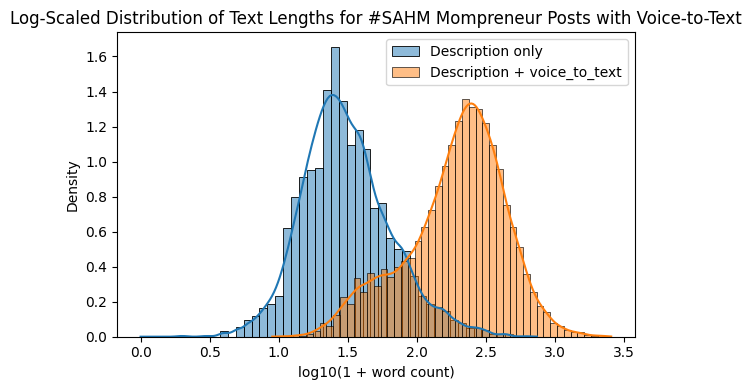

In [7]:
# Match transform (log10, add 1)
df_posts["log_len_desc"] = np.log10(1 + df_posts["n_words_desc"].fillna(0))
df_posts["log_len_desc_vt"] = np.log10(1 + df_posts["n_words_desc_vt"].fillna(0))

plt.figure(figsize=(6, 4))
bins = 50

sns.histplot(
    df_posts["log_len_desc"],
    bins=bins,
    stat="density",
    kde=True,
    label="Description only",
    alpha=0.5,
)
sns.histplot(
    df_posts["log_len_desc_vt"],
    bins=bins,
    stat="density",
    kde=True,
    label="Description + voice_to_text",
    alpha=0.5,
)

plt.title("Log-Scaled Distribution of Text Lengths for #SAHM Mompreneur Posts with Voice-to-Text")
plt.xlabel("log10(1 + word count)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.api as sm

In [24]:
POST_PATH = "data_sanitized/post_level_sanitized.csv"
CREATOR_PATH = "data_sanitized/creator_stats.csv"
CREATOR_YEAR_PATH = "data_sanitized/creator_year_stats.csv"
METRICS_PATH = "data_sanitized/model_metrics.csv"
HUMAN_CM_PATH = "data_sanitized/human_validation_confusion.csv"

df_posts = pd.read_csv(POST_PATH)
df_creator = pd.read_csv(CREATOR_PATH)
df_creator_year = pd.read_csv(CREATOR_YEAR_PATH)

model_metrics = pd.read_csv(METRICS_PATH) if os.path.exists(METRICS_PATH) else None
human_cm = pd.read_csv(HUMAN_CM_PATH) if os.path.exists(HUMAN_CM_PATH) else None

os.makedirs("figures", exist_ok=True)
os.makedirs("tables", exist_ok=True)

print("posts:", df_posts.shape)
print("creator:", df_creator.shape)
print("creator_year:", df_creator_year.shape)
print("metrics:", None if model_metrics is None else model_metrics.shape)
print("human_cm:", None if human_cm is None else human_cm.shape)

posts: (48971, 17)
creator: (5510, 7)
creator_year: (6843, 5)
metrics: (2, 7)
human_cm: (1, 7)


In [10]:
if model_metrics is None:
    print("model_metrics.csv not found. Make sure Notebook A wrote data_sanitized/model_metrics.csv")
else:
    # Keep only columns we want to show
    table1 = model_metrics[[
        "model", "accuracy", "precision_promo", "recall_promo", "f1_promo", "n_train", "n_val"
    ]].copy()

    # Round for display
    for col in ["accuracy", "precision_promo", "recall_promo", "f1_promo"]:
        table1[col] = table1[col].astype(float).round(3)

    print(table1.to_string(index=False))

    # Save
    table1.to_csv("tables/table1_model_comparison.csv", index=False)

          model  accuracy  precision_promo  recall_promo  f1_promo  n_train  n_val
   caption_only     0.925            0.607         0.891     0.722    17179   4295
caption_plus_vt     0.971            0.819         0.944     0.877    17179   4295


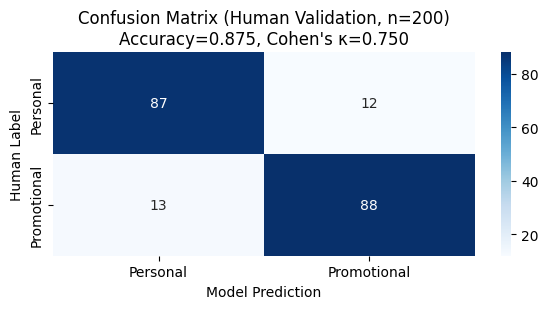

In [25]:
if human_cm is None:
    print("human_validation_confusion.csv not found. Make sure Notebook A wrote data_sanitized/human_validation_confusion.csv")
else:
    row = human_cm.iloc[0]
    tn, fp, fn, tp = int(row["tn"]), int(row["fp"]), int(row["fn"]), int(row["tp"])
    acc = float(row.get("accuracy", np.nan))
    kappa = float(row.get("kappa", np.nan))
    n = int(row.get("n", tn + fp + fn + tp))

    cm = np.array([[tn, fp],
                   [fn, tp]])

    plt.figure(figsize=(6, 3.2))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Personal", "Promotional"],
        yticklabels=["Personal", "Promotional"]
    )
    plt.title(f"Confusion Matrix (Human Validation, n={n})\nAccuracy={acc:.3f}, Cohen's κ={kappa:.3f}")
    plt.xlabel("Model Prediction")
    plt.ylabel("Human Label")
    plt.tight_layout()
    plt.savefig("figures/fig2_confusion_matrix.png", dpi=300)
    plt.show()

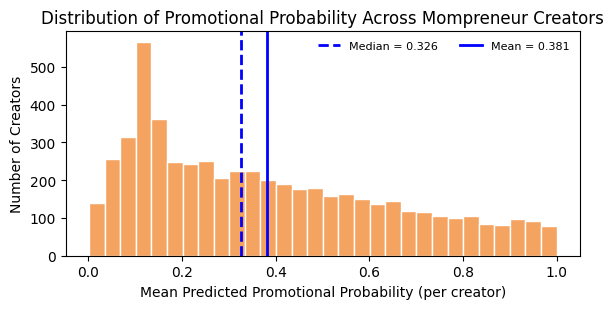

In [20]:
x = df_creator["mean_p_promotional"].dropna().astype(float)
q50 = float(x.median())
mean_val = float(x.mean())

plt.figure(figsize=(6, 3.2))
plt.hist(x, bins=30, edgecolor="white", color="sandybrown")
plt.axvline(q50, linestyle="--", color="blue", linewidth=2, label=f"Median = {q50:.3f}")
plt.axvline(mean_val, linestyle="-", color="blue", linewidth=2, label=f"Mean = {mean_val:.3f}")

plt.title("Distribution of Promotional Probability Across Mompreneur Creators")
plt.xlabel("Mean Predicted Promotional Probability (per creator)")
plt.ylabel("Number of Creators")
plt.legend(frameon=False, fontsize=8, ncol=2)
plt.tight_layout()
plt.savefig("figures/fig3_creator_promo_prob_hist.png", dpi=300)
plt.show()

In [13]:
MIN_YEARS = 3
MIN_POSTS_TOTAL = 20
TOP_N = 8
MIN_DELTA = 0.20

creator_totals = (
    df_creator_year
    .groupby("creator_id")
    .agg(
        total_posts=("n_posts", "sum"),
        n_years=("year", "nunique")
    )
    .reset_index()
)

eligible_ids = creator_totals.query(
    "total_posts >= @MIN_POSTS_TOTAL and n_years >= @MIN_YEARS"
)["creator_id"]

cy = df_creator_year[df_creator_year["creator_id"].isin(eligible_ids)].copy()
cy = cy.sort_values(["creator_id", "year"])

# Compute first/last values per creator WITHOUT groupby.apply
first = cy.groupby("creator_id").first().reset_index()
last = cy.groupby("creator_id").last().reset_index()

trend = first[["creator_id", "year", "frac_promotional"]].merge(
    last[["creator_id", "year", "frac_promotional"]], on="creator_id", suffixes=("_first", "_last")
)

trend = trend.merge(
    creator_totals[["creator_id", "total_posts", "n_years"]],
    on="creator_id",
    how="left"
)

trend["delta_frac"] = trend["frac_promotional_last"] - trend["frac_promotional_first"]

top_changers = trend[trend["delta_frac"] >= MIN_DELTA].sort_values(
    ["delta_frac", "total_posts"],
    ascending=[False, False]
).head(TOP_N)

picked_change = top_changers["creator_id"].tolist()
picked_change

['c7433e7ff3',
 '2ffeb241dd',
 'fead43c331',
 '82f4ebbb86',
 '9b73b7f165',
 '0b2f479a4d',
 '27b872e9a5',
 '1ee1012148']

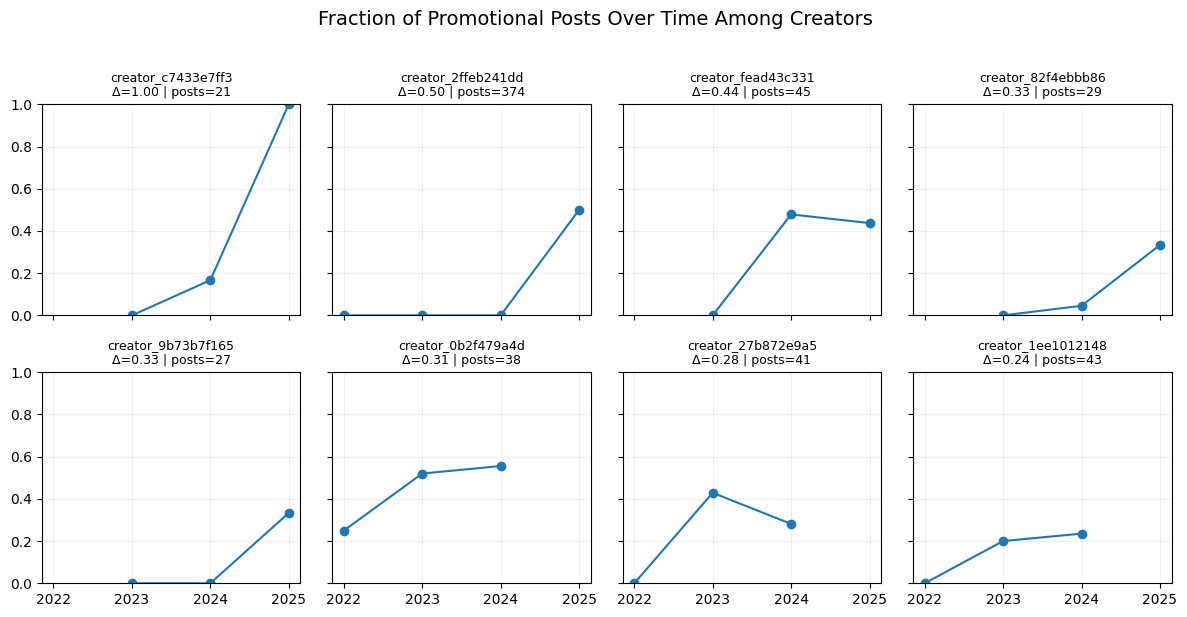

In [14]:
import math

def plot_small_multiples(creator_ids, title, subtitle_df=None):
    plot_df = df_creator_year[df_creator_year["creator_id"].isin(creator_ids)].copy()
    plot_df = plot_df.sort_values(["creator_id", "year"])

    cols = 4
    rows = math.ceil(len(creator_ids) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)

    subtitle_map = None
    if subtitle_df is not None:
        subtitle_map = subtitle_df.set_index("creator_id").to_dict(orient="index")

    for i, cid in enumerate(creator_ids):
        ax = axes[i]
        d = plot_df[plot_df["creator_id"] == cid]
        ax.plot(d["year"], d["frac_promotional"], marker="o", linewidth=1.5)
        ax.set_ylim(0, 1)
        ax.grid(alpha=0.2)

        label = f"creator_{cid}"
        if subtitle_map is not None and cid in subtitle_map:
            row = subtitle_map[cid]
            if "delta_frac" in row:
                label += f"\nΔ={row['delta_frac']:.2f}"
            if "total_posts" in row:
                label += f" | posts={int(row['total_posts'])}"
        ax.set_title(label, fontsize=9)

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.tight_layout()
    return fig

fig = plot_small_multiples(
    picked_change,
    title="Fraction of Promotional Posts Over Time Among Creators",
    subtitle_df=top_changers[["creator_id", "delta_frac", "total_posts"]]
)
fig.savefig("figures/fig4_creator_trajectories.png", dpi=300, bbox_inches="tight")
plt.show()

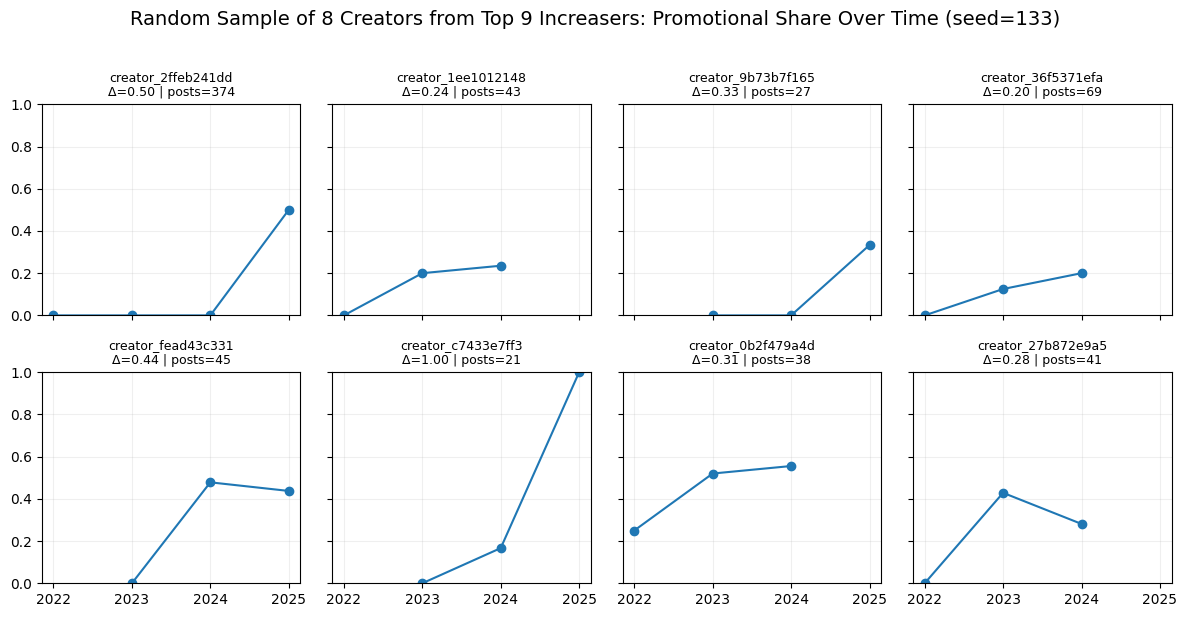

In [37]:
# How many creators to plot (8 panels total)
TOP_N = 8

# Define the size of the "top pool" we sample from.
# We'll rank creators by increase in promotional share, take the top K,
# then randomly sample TOP_N creators from that top-K pool.
K = 50

# Random seed for reproducibility (same seed => same sampled creators)
SEED = 133

# Eligibility filters (to avoid very sparse/noisy creator trajectories)
MIN_TOTAL_POSTS = 20  # creator must have at least this many posts total across years
MIN_YEARS = 3         # creator must appear in at least this many distinct years
MIN_DELTA = 0.20      # creator must have promo share change by at least this amount (0 to 1 scale)

# ---------------------------
# 1) Compute total posts + number of active years per creator
# ---------------------------
creator_totals = (
    df_creator_year
    .groupby("creator_id")  # one row per creator_id
    .agg(
        total_posts=("n_posts", "sum"),  # sum posts across all years
        n_years=("year", "nunique")      # count distinct years observed
    )
    .reset_index()
)

# ---------------------------
# 2) Restrict to "eligible" creators who have enough posts + enough years
# ---------------------------
eligible_ids = creator_totals.loc[
    (creator_totals["total_posts"] >= MIN_TOTAL_POSTS) &
    (creator_totals["n_years"] >= MIN_YEARS),
    "creator_id"
]

# Keep only the eligible creators in the creator-year time series table
cy = df_creator_year[df_creator_year["creator_id"].isin(eligible_ids)].copy()

# Sort so that "first" and "last" year per creator are well-defined
cy = cy.sort_values(["creator_id", "year"])

# ---------------------------
# 3) Compute each creator’s change in promotional fraction:
#    delta_frac = (last year frac_promotional) - (first year frac_promotional)
# ---------------------------

# For each creator, grab the first year row (earliest year after sorting)
first = cy.groupby("creator_id").first().reset_index()

# For each creator, grab the last year row (latest year after sorting)
last = cy.groupby("creator_id").last().reset_index()

# Merge first + last to put them on the same row per creator_id
trend = first[["creator_id", "frac_promotional"]].merge(
    last[["creator_id", "frac_promotional"]],
    on="creator_id",
    suffixes=("_first", "_last")  # rename columns so we can distinguish
)

# Add creator totals (posts/years) to this per-creator trend table
trend = trend.merge(creator_totals, on="creator_id", how="left")

# Compute change in promo share from first to last year
trend["delta_frac"] = trend["frac_promotional_last"] - trend["frac_promotional_first"]

# Optionally restrict to creators with at least MIN_DELTA increase
# (If you want a purely top-K without a hard cutoff, delete this next line.)
trend = trend[trend["delta_frac"] >= MIN_DELTA].copy()

# ---------------------------
# 4) Rank creators by delta (and tie-break by total posts), take top K,
#    then randomly sample TOP_N creators from that set
# ---------------------------

# Sort descending: biggest increase first; if tied, prefer higher total_posts
topK = (
    trend
    .sort_values(["delta_frac", "total_posts"], ascending=[False, False])
    .head(K)
    .copy()
)

# Extract the creator_id pool we will sample from
pool = topK["creator_id"].to_numpy()

# Defensive check: ensure we can sample TOP_N unique creators
if len(pool) < TOP_N:
    raise ValueError(
        f"Top-K pool too small ({len(pool)}) for TOP_N={TOP_N}. "
        "Try lowering MIN_DELTA/MIN_YEARS/MIN_TOTAL_POSTS or increasing K."
    )

# Seeded RNG for reproducible "random" selection
rng = np.random.default_rng(SEED)

# Randomly pick TOP_N creator_ids from the top-K pool without replacement
picked_change = rng.choice(pool, size=TOP_N, replace=False).tolist()

# ---------------------------
# 5) Plot the selected creators using your existing plot_small_multiples
# ---------------------------

# Use the topK table for subtitles so we can display Δ and total_posts
fig = plot_small_multiples(
    picked_change,
    title=(
        f"Random Sample of {TOP_N} Creators from Top {min(K, len(pool))} Increasers: "
        f"Promotional Share Over Time (seed={SEED})"
    ),
    subtitle_df=topK[["creator_id", "delta_frac", "total_posts"]]
)

# Save figure to disk (public notebook output)
fig.savefig("figures/fig4_creator_trajectories_topK_random.png", dpi=300, bbox_inches="tight")

# Display the figure
plt.show()

## Promo vs engagement + OLS regression

### Build plot + regression dataset

In [15]:
df_reg = df_creator.copy()

# Ensure numeric
for c in ["mean_p_promotional", "total_posts", "median_like_rate", "median_words"]:
    df_reg[c] = pd.to_numeric(df_reg[c], errors="coerce")

df_reg = df_reg.dropna(subset=["mean_p_promotional", "total_posts", "median_like_rate", "median_words"]).copy()

# Poster transform
df_reg["log1p_median_like_rate"] = np.log1p(df_reg["median_like_rate"])

df_reg.shape

(5497, 8)

### Scatter plot

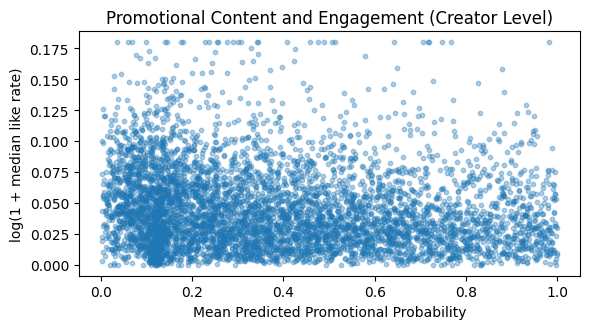

In [16]:
plt.figure(figsize=(6, 3.4))
plt.scatter(df_reg["mean_p_promotional"], df_reg["log1p_median_like_rate"], alpha=0.35, s=10)

plt.title("Promotional Content and Engagement (Creator Level)")
plt.xlabel("Mean Predicted Promotional Probability")
plt.ylabel("log(1 + median like rate)")
plt.tight_layout()
plt.savefig("figures/fig5_promo_vs_engagement_scatter.png", dpi=300)
plt.show()

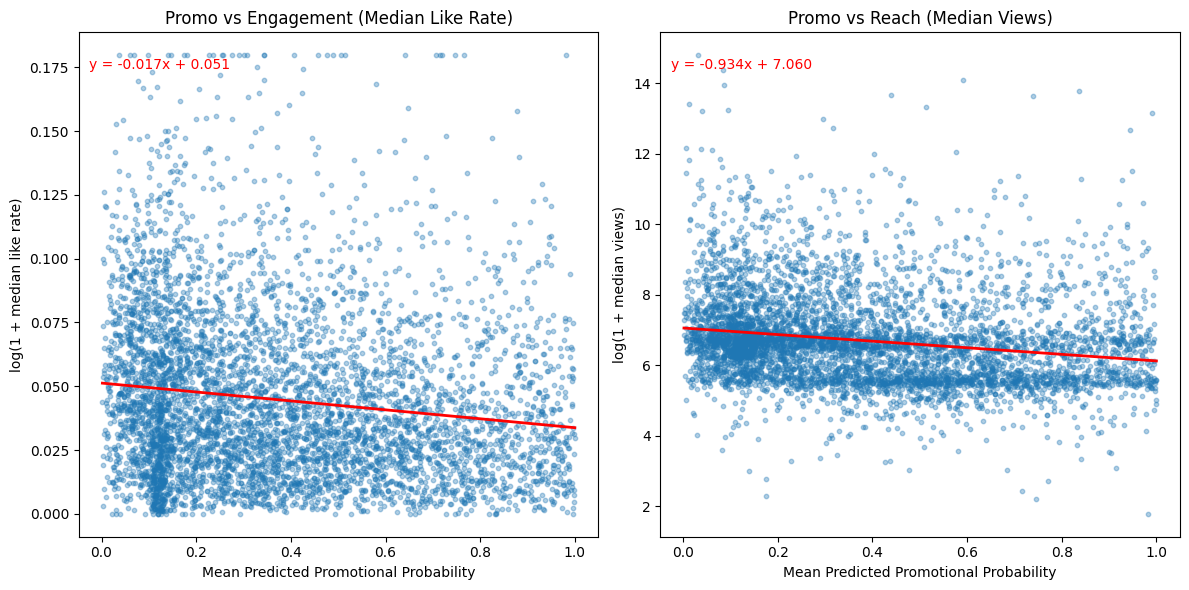

In [19]:
# --- 1) Ensure creator-level "median_views" exists ---
if "median_view_count" in df_reg.columns:
    df_reg["median_views"] = pd.to_numeric(df_reg["median_view_count"], errors="coerce")
elif "median_views" in df_reg.columns:
    df_reg["median_views"] = pd.to_numeric(df_reg["median_views"], errors="coerce")
else:
    # compute from post-level sanitized data
    # df_posts must have creator_id and view_count
    creator_views = (
        df_posts.assign(view_count=pd.to_numeric(df_posts["view_count"], errors="coerce"))
        .groupby("creator_id")["view_count"]
        .median()
        .reset_index()
        .rename(columns={"view_count": "median_views"})
    )
    df_reg = df_reg.merge(creator_views, on="creator_id", how="left")

# --- 2) Build transformed variables for plotting ---
df_reg["mean_p_promotional"] = pd.to_numeric(df_reg["mean_p_promotional"], errors="coerce")
df_reg["median_like_rate"] = pd.to_numeric(df_reg["median_like_rate"], errors="coerce")
df_reg["median_views"] = pd.to_numeric(df_reg["median_views"], errors="coerce")

df_reg["log1p_median_like_rate"] = np.log1p(df_reg["median_like_rate"])
df_reg["log1p_median_views"] = np.log1p(df_reg["median_views"])

# Drop missing/invalid
plot_df = df_reg.dropna(subset=["mean_p_promotional", "log1p_median_like_rate", "log1p_median_views"]).copy()

# --- 3) Helper: fit a line + equation string ---
def fit_line_and_eq(x, y):
    # simple least-squares line y = m x + b
    m, b = np.polyfit(x, y, 1)
    return m, b, f"y = {m:.3f}x + {b:.3f}"

# --- 4) Create side-by-side plots ---
x = plot_df["mean_p_promotional"].values

y_like = plot_df["log1p_median_like_rate"].values
m1, b1, eq1 = fit_line_and_eq(x, y_like)

y_views = plot_df["log1p_median_views"].values
m2, b2, eq2 = fit_line_and_eq(x, y_views)

# line x-range
x_line = np.linspace(np.nanmin(x), np.nanmax(x), 200)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# --- Panel A: Like rate ---
axes[0].scatter(x, y_like, alpha=0.35, s=10)
axes[0].plot(x_line, m1 * x_line + b1, color="red", linewidth=2)
axes[0].set_title("Promo vs Engagement (Median Like Rate)")
axes[0].set_xlabel("Mean Predicted Promotional Probability")
axes[0].set_ylabel("log(1 + median like rate)")
axes[0].text(
    0.02, 0.95, eq1,
    transform=axes[0].transAxes,
    va="top", ha="left",
    color="red", fontsize=10
)

# --- Panel B: Views ---
axes[1].scatter(x, y_views, alpha=0.35, s=10)
axes[1].plot(x_line, m2 * x_line + b2, color="red", linewidth=2)
axes[1].set_title("Promo vs Reach (Median Views)")
axes[1].set_xlabel("Mean Predicted Promotional Probability")
axes[1].set_ylabel("log(1 + median views)")
axes[1].text(
    0.02, 0.95, eq2,
    transform=axes[1].transAxes,
    va="top", ha="left",
    color="red", fontsize=10
)

plt.tight_layout()
plt.savefig("figures/fig5_promo_vs_like_and_views.png", dpi=300)
plt.show()

### OLS regression + save summary table

In [17]:
# OLS: y = log(1 + median like rate)
y = df_reg["log1p_median_like_rate"]

# X: mean promo prob + controls
X = df_reg[["mean_p_promotional", "total_posts", "median_words"]].copy()

# optional log-transform posts to reduce skew (comment out if you want raw)
X["log1p_total_posts"] = np.log1p(X["total_posts"])
X = X.drop(columns=["total_posts"])

X = sm.add_constant(X)

model = sm.OLS(y, X, missing="drop").fit()
print(model.summary())

# Save a clean coefficient table for the poster / writeup
coef_table = pd.DataFrame({
    "term": model.params.index,
    "coef": model.params.values,
    "se": model.bse.values,
    "t": model.tvalues.values,
    "p": model.pvalues.values,
})
coef_table.to_csv("tables/ols_creator_engagement.csv", index=False)
coef_table


                              OLS Regression Results                              
Dep. Variable:     log1p_median_like_rate   R-squared:                       0.033
Model:                                OLS   Adj. R-squared:                  0.032
Method:                     Least Squares   F-statistic:                     62.41
Date:                    Mon, 22 Dec 2025   Prob (F-statistic):           1.13e-39
Time:                            13:04:59   Log-Likelihood:                 11144.
No. Observations:                    5497   AIC:                        -2.228e+04
Df Residuals:                        5493   BIC:                        -2.225e+04
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

,term,coef,se,t,p
0,const,0.044608,0.001091,40.891440,0.000000e+00
1,mean_p_promotional,-0.017987,0.001693,-10.621124,4.251442e-26
2,median_words,0.000010,0.000003,3.462944,5.383748e-04
3,log1p_total_posts,0.003118,0.000432,7.210878,6.311718e-13
